# Random Forest

# Train on image 1 and validate on image 2
we remove uncertain data to train the model, and we use the entire dataset for prediction 
for accuracy, we have to remove uncertain data also

In [13]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names


# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
x_train1 = train_on1.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate2 = validate_on2.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_validate2 = validate_on2['expert_label'] # response variable we want to predict

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_4617/4023613531.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)


In [14]:
# Model 1: training using the default parameter 
rf = RandomForestClassifier()
rf.fit(x_train1, y_train1)
#y_pred_on2 = rf.predict(image_2.drop(columns=['expert_label'])) #prediction using entire image 2 data
accuracy_model_1 = rf.score(x_validate2, y_validate2) #accuracy of the model (have to drop )

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_validate2, rf.predict(x_validate2)))

              precision    recall  f1-score   support

        -1.0       0.91      0.81      0.86     42882
         1.0       0.82      0.91      0.86     39266

    accuracy                           0.86     82148
   macro avg       0.86      0.86      0.86     82148
weighted avg       0.86      0.86      0.86     82148



In [9]:
features = pd.DataFrame(rf.feature_importances_, index=x_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
NDAI,0.332667
Radiance_angle_AF,0.139964
y_coor,0.112769
Radiance_angle_BF,0.101672
x_coor,0.083891
SD,0.076742
Radiance_angle_AN,0.064822
Radiance_angle_CF,0.049821
Radiance_angle_DF,0.022037
CORR,0.015614


model 1 gives a 82% accuracy 

## Now I try to pick the best hyperparameters through grid search. I tune the hyperparameters for the full model by running the trainhyper.py file on SCF. The results for the best hyperparameters in the full model are saved in results folder. The hyperparameter tuning process performed two fold validation: train on image 1 and test on image 2, train on image 2 and test on image 1. Roc_auc is the metric we used to select the best set of hyperparameters. 

In [ ]:
#load csv file
hyper_p_results = pd.read_csv("../../../results/grid_search_results_full_model.csv") #this is the grid search result for choosing the hyperparameters

## best roc_auc: 0.9434
## best hyperparameters: "{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}"
## random state=42

# Now we use the best set of parameters to perform modeling on both image 1 and image 2 data combined

In [2]:
rf_best_hyper1 = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=4, bootstrap=True, criterion='entropy', random_state=42)
x_combined_train = pd.concat([x_train1, x_validate2])
y_combined_train = pd.concat([y_train1, y_validate2])

In [3]:
rf_best_hyper1.fit(x_combined_train, y_combined_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       n_estimators=200, random_state=42)

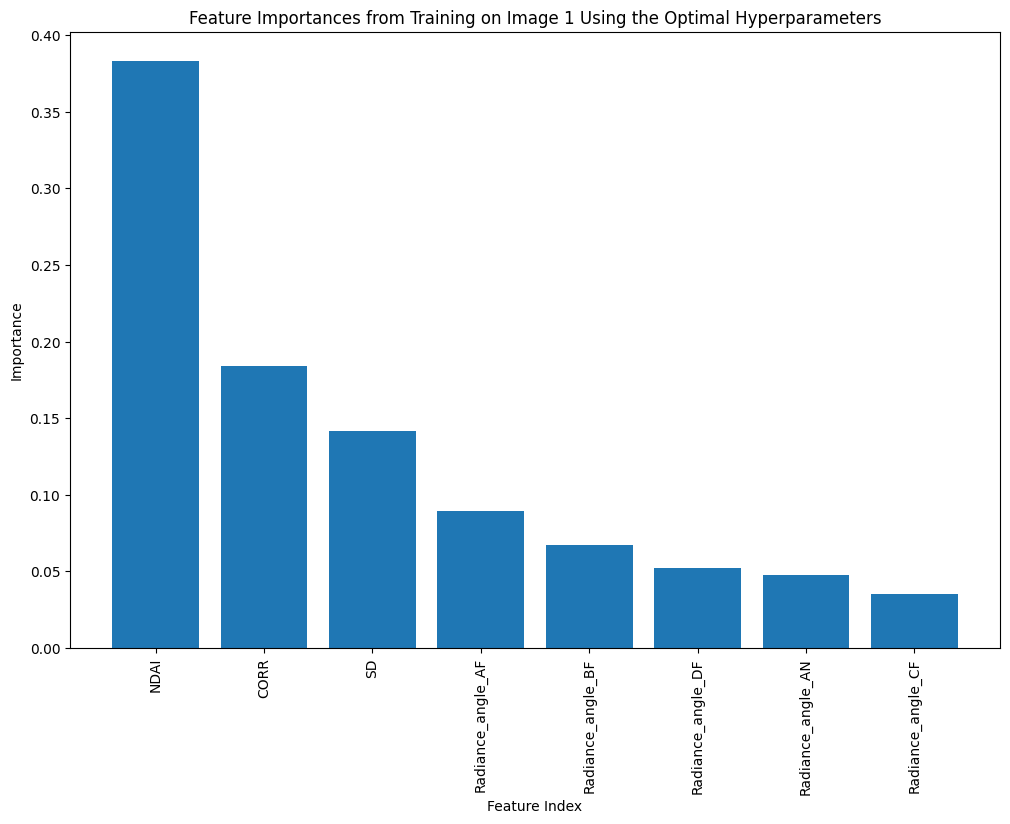

In [4]:
features = pd.DataFrame(rf_best_hyper1.feature_importances_, index=x_combined_train.columns, columns=['importance']).sort_values('importance', ascending=False)
features

plt.figure(figsize=(12, 8))
plt.bar(features.index, features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Training on Image 1 Using the Optimal Hyperparameters')
plt.xticks(ticks=features.index, rotation=90)
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(validate_on2['expert_label'], rf_best_hyper1.predict(validate_on2.drop(columns=['expert_label']))))

              precision    recall  f1-score   support

        -1.0       0.87      0.85      0.86     42882
         1.0       0.84      0.87      0.85     39266

    accuracy                           0.86     82148
   macro avg       0.86      0.86      0.86     82148
weighted avg       0.86      0.86      0.86     82148



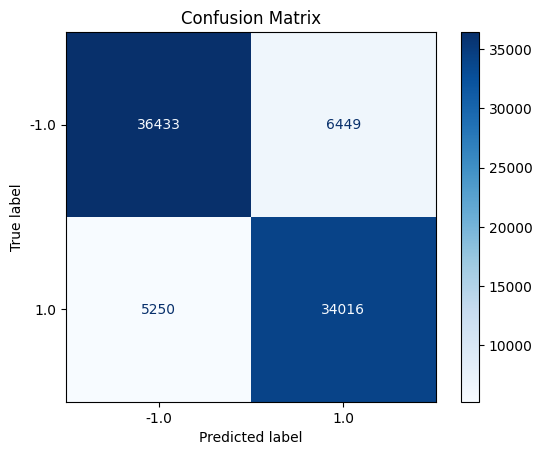

In [12]:
#predict using rf_best_hyper1 on image 2 data
confusion_matrix1 = confusion_matrix(validate_on2['expert_label'], rf_best_hyper1.predict(validate_on2.drop(columns=['expert_label'])))
confusion_matrix1

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=rf_best_hyper1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# below is just testing my python script for tuning hyperparameters for SCF, can ignore

In [1]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names


# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
#drop expert_label and x_coor, y_coor
#Don't use X and Y coordinates as features 
x_train1 = train_on1.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

#drop expert_label and x_coor, y_coor
x_validate2 = validate_on2.drop(columns=['expert_label', 'x_coor', 'y_coor']) # explanatory variables
y_validate2 = validate_on2['expert_label'] # response variable we want to predict

# Try to tune the hyperparameters using gridsearch and cross validation (train on 1 and validate on 2)
rf = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [100, 200, 300], # number of trees in the forest, default=100. usually more trees better performance
#'max_depth': [None, 10, 20, 30], # the maximum depth of the tree, default=none. may lead to overfitting if the depth too large
#'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node, default=2 (the node will split as long as it has at least 2 samples). high values prevent overfitting
#'min_samples_leaf': [1, 2, 4], # the minimum number of samples required to be at a leaf node, default=1. large values prevent overfitting
#'criterion': ['gini', 'entropy'], # the function to measure the quality of a split, default=gini. 
#'bootstrap': [True, False] # whether bootstrap samples are used when building trees, default=True
}

# Create a validation fold
X = pd.concat([x_train1, x_validate2], ignore_index=True)
y = pd.concat([y_train1, y_validate2], ignore_index=True)

# Create test_fold array for both splits simultaneously
test_fold = np.ones(len(X))  # Initialize with 1s (won't be used in CV)
test_fold[:len(x_train1)] = 0  # Elements with 0 are treated as validation data in split 1.
test_fold[len(x_train1):] = 1  # Elements with 1 are treated as validation data in split 2.
#should not use "-1" index because it will always be training. 
# With 0, 1 index, cv in Gridsearchcv will consider two scenarios: 0 as training and 1 as validation, and 1 as training and 0 as validation

# Create PredefinedSplit object
ps = PredefinedSplit(test_fold)

# Define multiple scoring metrics
scoring = {
    'roc_auc': 'roc_auc',        # Area Under the ROC Curve
    'accuracy': 'accuracy'      # Accuracy score
}

# Use GridSearchCV with the combined predefined split
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           cv=ps, 
                           refit='roc_auc', # Specify which metric to use for choosing the best model
                           n_jobs=-1)

# Fit the model with combined data
grid_search.fit(X, y)

# Access and print the results
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('grid_search_results_full_model.csv', index=False)
best_roc_auc = grid_search.cv_results_['mean_test_roc_auc'].max()
best_accuracy = grid_search.cv_results_['mean_test_accuracy'].max()
best_params=grid_search.best_params_
# Create a dictionary to hold the best parameters and score
results_parameter = {
   'best_roc_auc': [best_roc_auc],
   'best_accuracy': [best_accuracy],
   'best_params': [best_params]
}

results_parameter = pd.DataFrame(results_parameter)
results_parameter.to_csv('results_parameter.csv', index=False)

# Save the best model
#joblib.dump(best_rf, 'best_random_forest_model.pkl')

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_6972/644532051.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../../data/image_data/image3.txt", delim_whitespace=True, header=None)
/opt/miniconda3/envs/215a/lib/pyth